In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

In [3]:
df = pd.read_csv("datosentrenar.csv")
df.head()
len(df)

1500

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
print(df["label"].value_counts())

cuda
label
0    771
1    729
Name: count, dtype: int64


In [5]:
class_0 = df[df["label"]==0].sample(771)
class_1 = df[df["label"]==1].sample(729)
balanced_df = pd.concat([class_0, class_1]).sample(frac=1).reset_index(drop=True)
len(balanced_df)

1500

In [6]:
data = balanced_df.drop(columns=["label"]).values
labels = balanced_df["label"].values

# Step 2: Scale the data
data = data / np.max(data)

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Step 3: Convert the data and labels to PyTorch tensors
data = torch.tensor(data, dtype=torch.float32).to(device)
labels = torch.tensor(labels, dtype=torch.long).to(device)  # Use long for classification labels

# Step 4: Unsqueeze the data to add a channel dimension
data = data.unsqueeze(1)

# Step 5: Split data into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)

# Print the amount of 1s and 0s in the labels
print(f"Number of 1s in the labels: {int(torch.sum(test_labels))}")
print(f"Number of 0s in the labels: {len(test_labels) - int(torch.sum(test_labels))}")

# Step 6: Create TensorDatasets for training and testing
train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

# Create DataLoaders for training and testing
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print the shape of the data
print(f"Shape of training data: {train_data.shape}")
print(f"Shape of test data: {test_data.shape}")

Number of 1s in the labels: 129
Number of 0s in the labels: 171
Shape of training data: torch.Size([1200, 1, 11772])
Shape of test data: torch.Size([300, 1, 11772])


In [7]:
class Abraham_CNN(nn.Module):
    def __init__(self):
        super(Abraham_CNN, self).__init__()
        self.activation = nn.SiLU()
        self.maxpool = nn.MaxPool1d(kernel_size=2, stride=4, padding=0)
        self.conv1 = nn.Conv1d(1, 64, kernel_size=16, stride=1)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=16, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=16, stride=1, padding=1)
        self.bn3 = nn.BatchNorm1d(256)
        self.conv4 = nn.Conv1d(256, 512, kernel_size=16, stride=1, padding=1)
        self.bn4 = nn.BatchNorm1d(512)
        self.conv5 = nn.Conv1d(512, 1024, kernel_size=16, stride=1, padding=1)
        self.bn5 = nn.BatchNorm1d(1024)
        self.flatten = nn.Flatten()
        self.fc_input_size = self._calculate_fc_input_size()
        self.fc1 = nn.Linear(self.fc_input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 2)

    def _calculate_fc_input_size(self):
        with torch.no_grad():
            input_tensor = torch.zeros(1, 1, 11772)
            output = self.maxpool(self.activation(self.bn1(self.conv1(input_tensor))))
            output = self.maxpool(self.activation(self.bn2(self.conv2(output))))
            output = self.maxpool(self.activation(self.bn3(self.conv3(output))))
            output = self.maxpool(self.activation(self.bn4(self.conv4(output))))
            output = self.maxpool(self.activation(self.bn5(self.conv5(output))))
            return output.numel()

    def forward(self, x):
        x = self.maxpool(self.activation(self.bn1(self.conv1(x))))
        x = self.maxpool(self.activation(self.bn2(self.conv2(x))))
        x = self.maxpool(self.activation(self.bn3(self.conv3(x))))
        x = self.maxpool(self.activation(self.bn4(self.conv4(x))))
        x = self.maxpool(self.activation(self.bn5(self.conv5(x))))
        x = self.flatten(x)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Abraham_CNN().to(device)
print(model)

Abraham_CNN(
  (activation): SiLU()
  (maxpool): MaxPool1d(kernel_size=2, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv1d(1, 64, kernel_size=(16,), stride=(1,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(64, 128, kernel_size=(16,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(128, 256, kernel_size=(16,), stride=(1,), padding=(1,))
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv1d(256, 512, kernel_size=(16,), stride=(1,), padding=(1,))
  (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv1d(512, 1024, kernel_size=(16,), stride=(1,), padding=(1,))
  (bn5): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features

Epoch 1/150, Loss: 0.73319, Accuracy: 49.67%
Epoch 2/150, Loss: 0.7109, Accuracy: 48.5%
Epoch 3/150, Loss: 0.7039, Accuracy: 49.5%
Epoch 4/150, Loss: 0.70658, Accuracy: 52.25%
Epoch 5/150, Loss: 0.70137, Accuracy: 50.25%
Epoch 6/150, Loss: 0.69938, Accuracy: 47.92%
Epoch 7/150, Loss: 0.69733, Accuracy: 47.75%
Epoch 8/150, Loss: 0.69544, Accuracy: 48.0%
Epoch 9/150, Loss: 0.67351, Accuracy: 58.08%
Epoch 10/150, Loss: 0.49997, Accuracy: 75.58%
Epoch 11/150, Loss: 0.28548, Accuracy: 85.33%
Epoch 12/150, Loss: 0.26896, Accuracy: 86.25%
Epoch 13/150, Loss: 0.25259, Accuracy: 86.42%
Epoch 14/150, Loss: 0.24114, Accuracy: 85.67%
Epoch 15/150, Loss: 0.23327, Accuracy: 85.83%
Epoch 16/150, Loss: 0.21982, Accuracy: 86.08%
Epoch 17/150, Loss: 0.21438, Accuracy: 86.5%
Epoch 18/150, Loss: 0.20882, Accuracy: 88.42%
Epoch 19/150, Loss: 0.20611, Accuracy: 88.83%
Epoch 20/150, Loss: 0.1822, Accuracy: 90.33%
Epoch 21/150, Loss: 0.1763, Accuracy: 88.83%
Epoch 22/150, Loss: 0.18074, Accuracy: 91.08%
Epoch

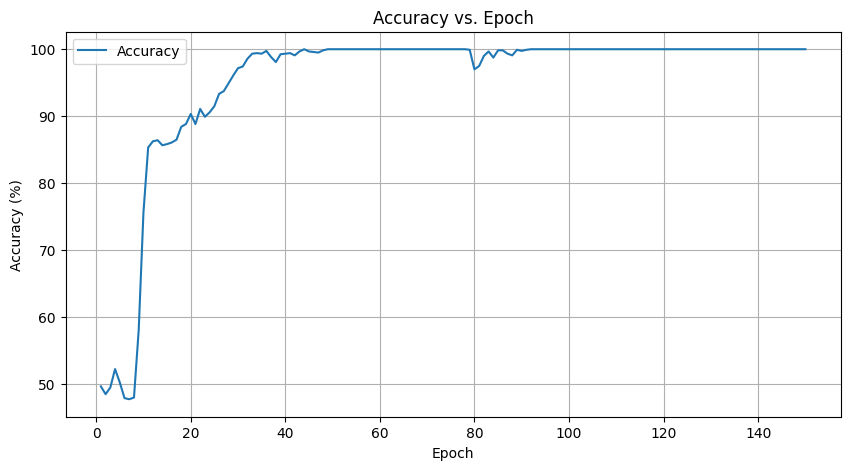

In [8]:

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 150
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move to device

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {round(epoch_loss,5)}, Accuracy: {round(epoch_accuracy,2)}%")
        
# Plot the accuracy values
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs. Epoch')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
# Saving model weights
torch.save(model.state_dict(), 'model_weights.pth')

In [10]:

def get_predictions(model, data_loader):
    model.load_state_dict(torch.load('model_weights.pth'))
    model.eval()  # Set the model to evaluation mode
    predictions = []
    actuals = []

    with torch.no_grad():  # Disable gradient computation for inference
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move to device
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            predictions.extend(predicted.cpu().numpy())
            actuals.extend(labels.cpu().numpy())

    return predictions, actuals

# Get predictions and actuals from the test set
predictions, actuals = get_predictions(model, test_loader)

# Calculate accuracy
correct_predictions = sum(int(p == a) for p, a in zip(predictions, actuals))
accuracy = correct_predictions / len(actuals) * 100

# Print some of the predictions and actual labels to verify
for i in range(10):  
    print(f'Prediction: {predictions[i]}, Actual: {actuals[i]}')

# Print accuracy
print(f'Accuracy: {accuracy:.2f}%')

# Calculate and print additional metrics
conf_matrix = confusion_matrix(actuals, predictions)
precision = precision_score(actuals, predictions)
recall = recall_score(actuals, predictions)
f1 = f1_score(actuals, predictions)

print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

Prediction: 0, Actual: 0
Prediction: 0, Actual: 0
Prediction: 0, Actual: 0
Prediction: 1, Actual: 1
Prediction: 0, Actual: 0
Prediction: 0, Actual: 1
Prediction: 1, Actual: 1
Prediction: 1, Actual: 1
Prediction: 0, Actual: 1
Prediction: 1, Actual: 1
Accuracy: 88.00%
Confusion Matrix:
[[154  17]
 [ 19 110]]
Precision: 0.87
Recall: 0.85
F1 Score: 0.86
